序列数据:
起因: 实际生活中, 很多数据都具有时序结构; 人们对一个事物的态度跟许多因素有关, 随时序而变化; 数据是连续的, 前后关联和先后顺序很重要
时序性的体现: 当我们在时间t时观察到了xt, 则我们会得到t个不独立的随机变量(x1,x2,...,xt)~p(X)
将这个随机变量拆开:

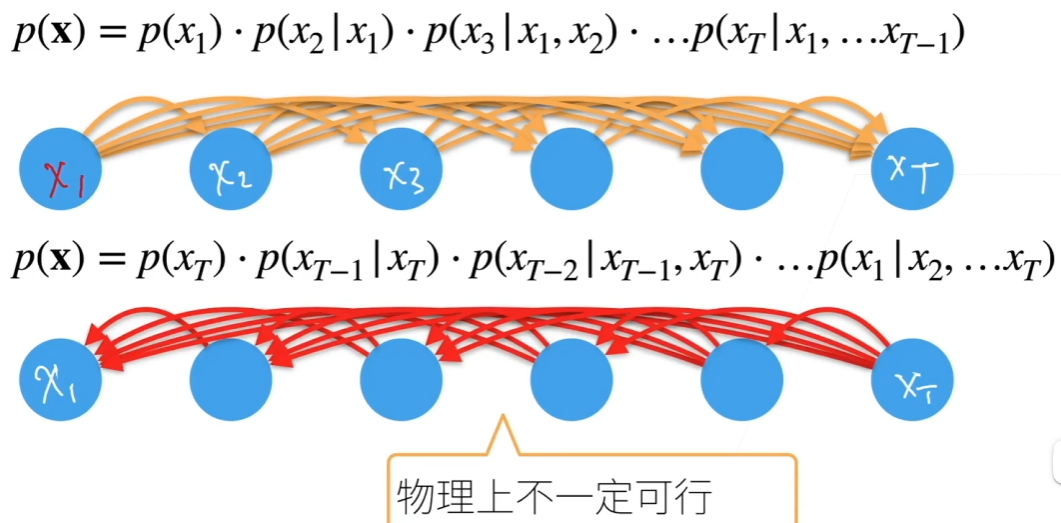

对条件概率建模:
对见过的数据进行建模, 将p(xt|x1,x2,...) => p(xt|f(x1,x2,...))
区别在如何如何计算f和p
方案1马尔科夫假设: 当前数据只跟τ个过去数据点有关
p(xt|x1,x2,...) => p(xt|f(xt-τ,x2,...))
方案2潜变量:
用ht来表示f(x1,x2,...), ht是一个变量, f是一个函数
问题就转换为了如何根据前面的h,x得到新的h, 和怎么根据新h和旧x得到新x

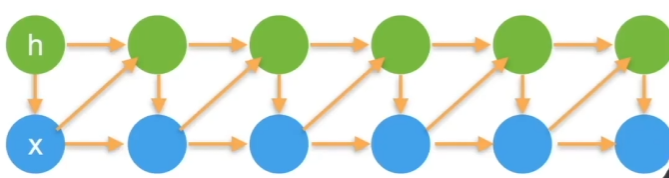

In [ ]:
# 文本预处理
import collections
import re
from d2l import torch as d2l

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    #  使用d2l.download('time_machine')下载数据集（如果本地不存在）并返回文件路径。
    # 打开文件，逐行读取内容到列表lines中
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
        # 用空格替换所有非字母字符
        # .strip()：移除行首尾的空白字符
        # .lower()：将文本转为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'
print(lines[0])
print(lines[10])

In [ ]:
# 分词
def tokenize(lines, token='word'):
    # token='word'​：使用 line.split() 按空格分割每行文本，返回单词列表
    if token == 'word':
        return [line.split() for line in lines]
    # token='char'​：使用 list(line) 将每行拆分为单个字符
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

In [ ]:
class Vocab:
    # 为每一个出现大于最小频率的词打上一个标记, 形成一个词典
    #输入​：tokens：标记列表（如 [['the', 'time'], ['by', 'h']]）。
    # min_freq：最小频率，低于此值的标记会被忽略。
    # reserved_tokens：预留标记（如 <bos>, <eos>）。
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
            # count_corpus 统计标记频率
        counter = count_corpus(tokens)
            # 按频率降序排序，过滤低频标记
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # 构建词汇表：<unk> + reserved_tokens + 高频标记
        #初始化未知标记
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        # 添加高频标记
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        # 构建双向映射
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token) # 添加标记到列表
            self.token_to_idx[token] = len(self.idx_to_token) - 1 # 记录标记→索引

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    """统计标记的频率。"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


In [ ]:
# 构建词汇表
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

In [ ]:
# 将每一行文本转换成一个数字索引列表
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

In [ ]:
# 打包之前的操作到load_corpus_time_machine函数中
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的标记索引列表和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

语言模型: 给定文本序列x1,x2,...xt; 模型目的是估计文本序列出现的联合概率p(x1,x2,...xt)
最简单的建模:计数(见下图)

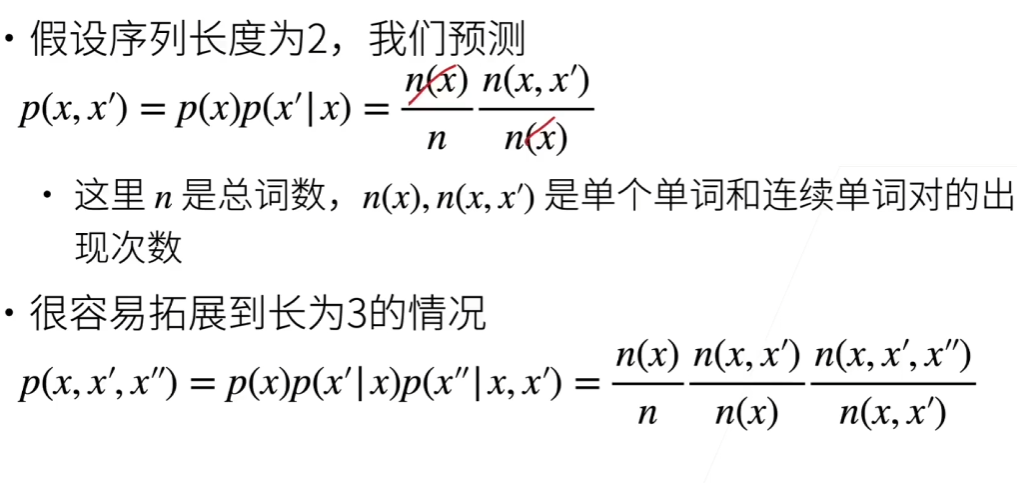

长序列的数据稀疏性​
当我们要计算一个 ​长序列​（如句子 x₁, x₂, ..., x_T）的联合概率时，需要统计整个序列在训练数据中出现的次数 n(x₁,…,x_T)。
​但现实情况​：如果序列很长（比如T很大），而训练数据量不够大，这个序列可能​从未出现过​（出现次数 ≤1），导致无法估计概率（概率值为0或极不准确）
主要问题: 训练数据不够大导致的
解决方案马尔科夫假设, 也许这个长句子没出现过, 但是拆分成τ个后也许就出现过了, 这就是N元语法

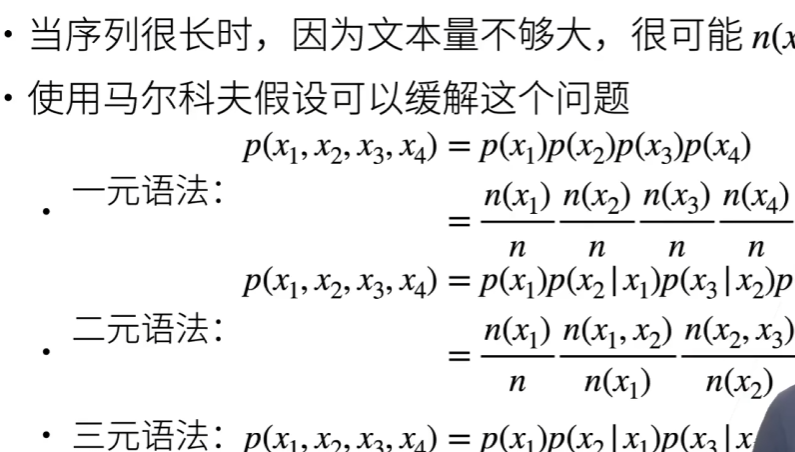

In [ ]:
import random
import torch
from d2l import torch as d2l

# d2l.tokenize()​ 对每行文本按空格分词
tokens = d2l.tokenize(d2l.read_time_machine())
# 将嵌套的 tokens 展平为一个一维列表 corpus，包含所有单词
corpus = [token for line in tokens for token in line]
# d2l.Vocab
vocab = d2l.Vocab(corpus)
# vocab.token_freqs: 返回一个按词频降序排列的列表，每个元素是 (单词, 频率) 的元组(查看词频最高的10个单词)
vocab.token_freqs[:10]

KeyboardInterrupt: 

​d2l.Vocab
根据 corpus 构建词汇表，自动完成以下操作：
1.统计每个单词的频率（如 {'the': 100, 'time': 50, ...}）。
2.按频率从高到低排序。
3.分配索引：
    索引 0 保留给未知词 <unk>。
    后续索引按频率分配（如 'the'→1, 'time'→2）。
4.生成两个映射：
    token_to_idx：单词到索引的字典（如 {'the': 1, 'time': 2}）。
    idx_to_token：索引到单词的列表（如 ['<unk>', 'the', 'time', ...]）。

In [ ]:
# ​可视化词汇表中单词的频率分布
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

In [ ]:
# 二元语法
# 输入: corpus 是单词列表（如 ['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ...]）
# 操作:
# corpus[:-1]：获取排除最后一个词的所有单词（如 ['the', 'time', 'machine', 'by', 'h', 'g']）
# corpus[1:]：获取排除第一个词的所有单词（如 ['time', 'machine', 'by', 'h', 'g', 'wells']）
# zip()：将两个列表逐对组合，生成二元组序列
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

In [ ]:
# 三元语法
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

In [ ]:
# ​可视化词汇表中单词的频率分布
# 小部分的词出现多, 大部分的词出现少
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [ ]:
# 用于生成随机抽样子序列的迭代器
# 输入​：
# corpus：语料库（一维列表，如字符或单词索引序列）。
# batch_size：每批次的样本数。
# num_steps：每个子序列的长度（时间步数）。
# ​输出​：生成器，逐批返回 (X, Y) 张量，其中 Y 是 X 的下一个时间步
def seq_data_iter_random(corpus, batch_size, num_steps):
    # 用一个step扫一遍数据, 所有数据只遍历过一次, 但是每次随机起始, 这样可以减少有些语句被分割在两段中的可能性
    # 随机偏移语料库: 随机选择起始位置
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 计算可生成子序列数: 每个子序列长 num_steps，相邻子序列不重叠。
    # 减1​ 的原因是为了确保每个子序列 X 都有对应的目标序列 Y（即 X 的下一个时间步），避免数据截断。
    num_subseqs = (len(corpus) - 1) // num_steps
    # 生成初始索引并打乱
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

# 定义子序列提取函数: 从位置 pos 提取长度为 num_steps 的子序列
    def data(pos):
        return corpus[pos:pos + num_steps]

# 分批生成数据
# 总批次数 num_batches = num_subseqs // batch_size
# 每批次取 batch_size 个子序列。
# X 是当前子序列，Y 是 X 的下一个时间步（右移1位）
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [ ]:
# 预测时, 我们的目的是什么: 给X,预测Y
# 第一种采样方法: 每个batch的采样都是独立的
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

In [ ]:
# 第二种采样方法: 保证两个相邻的batch中的子序列在原始序列上也是相邻的
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列。"""
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

In [ ]:
class SeqDataLoader:
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
# 统合上文代码生成的训练代码(现在还没有写data_iter_fn())
class SeqDataLoader:
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
# 最后，我们定义了一个函数 load_data_time_machine ，它同时返回数据迭代器和词汇表
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

循环神经网络:
观察->更新隐变量->输出(输出是为了预测观察, 输出内容只能从隐变量判断, 看不到观察内容)
可以看到, ht由ht-1,xt-1决定; ot仅由ht决定
若去掉 Whh ht−1项，RNN退化为多层感知机（MLP）​，失去记忆能力（无法处理时序数据）权重Wtt包含着时序数据

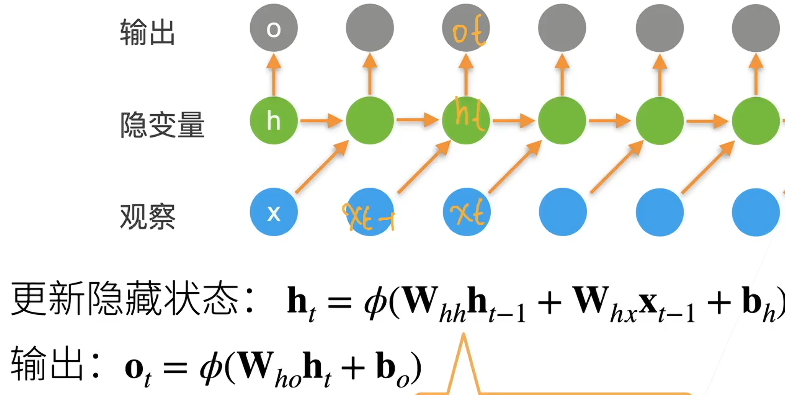

衡量一个语言模型的好坏:
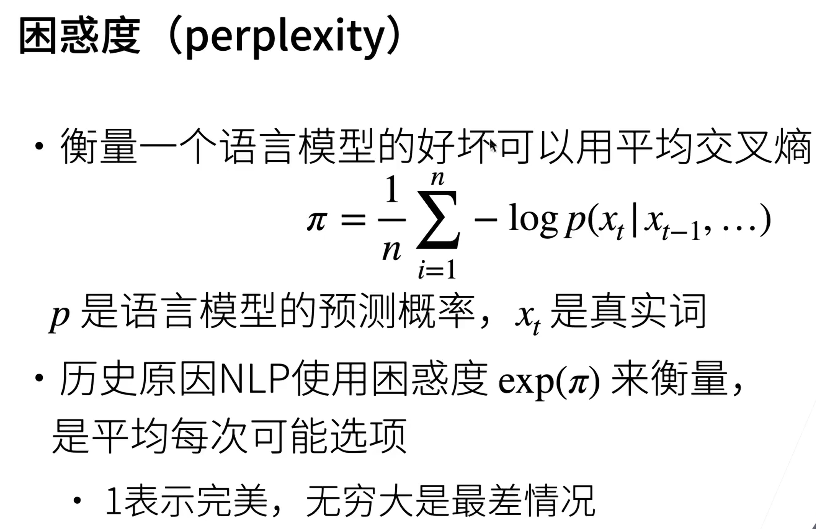

梯度裁剪
在RNN中，反向传播需要计算T个时间步的梯度，形成长度为 O(T) 的矩阵乘法链
​核心思想​：
对梯度向量的范数进行强制截断，确保其不超过预设阈值 θ。
若梯度 g 的范数 ∥g∥>θ，则按比例缩放：
g←g⋅∥g∥ ÷ θ
​
 
裁剪后梯度方向不变，但幅度受限。
​效果​：
避免参数更新过大，稳定训练过程。
不改变梯度的方向（仍指向损失下降的方向），仅限制步长。

In [ ]:
# RNN从0开始实现
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 批量的大小batch_size, 每次看多长的序列(文段)num_steps
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 将词索引转换为独热编码
F.one_hot(torch.tensor([0, 2]), len(vocab))
# 现在我们模拟一下之的操作, 对于一个batch_size=2, num_steps=5的小批量, 他是一个2*5的张量
X = torch.arange(10).reshape((2, 5))
# 由于one-hot会对输入张量的每个标量元素，生成一个长度为 num_classes（此处为 28）的独热向量
# 所以最后会变为3维
F.one_hot(X.T, 28).shape

为什么要转置:
维度对齐​：
RNN的输入通常要求形状为 (序列长度, 批量大小, 特征维度)，而原始数据 X 的 (2, 5) 可能不符合要求，转置后变为 (5, 2) 以匹配时间步优先的输入格式。
​数据逻辑​：
若 X 的原始维度是 (批量大小, 序列长度)，转置后可将序列维度（时间步）放在第一维，便于逐时间步处理。

In [ ]:
# 初始化循环神经网络模型的模型参数
# vocab_size: 输入和输出词汇表的大小
# num_hiddens: RNN隐藏层的单元数量
# device: 指定参数存储的设备（CPU或GPU）
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 辅助函数: 生成一个从 ​标准正态分布​（均值为0，标准差为1）中随机采样的张量，并乘以 0.01 缩小数值范围
    # 目的​：初始化权重矩阵（W_xh, W_hh, W_hq），使初始值较小，避免训练初期梯度爆炸或消失
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 权重初始化, 偏置初始化
    W_xh = normal((num_inputs, num_hiddens)) # 输入→隐藏层的权重
    W_hh = normal((num_hiddens, num_hiddens)) # 隐藏层→隐藏层的权重
    b_h = torch.zeros(num_hiddens, device=device) # 隐藏层的偏置
    W_hq = normal((num_hiddens, num_outputs)) # 隐藏层→输出层的权重
    b_q = torch.zeros(num_outputs, device=device)  # 输出层的偏置
    # 启用梯度计算
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    # 返回参数列表
    return params

In [ ]:
# 一个init_rnn_state函数在初始化时返回隐藏状态
# RNN的核心特点是 ​依赖隐藏状态（h_t）传递时序信息
# 为RNN模型创建一个全零的初始隐藏状态，确保训练或推理时从“零记忆”开始，逐步积累序列信息
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [ ]:
# rnn函数定义了如何在一个时间步计算隐藏状态和输出
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # 隐藏状态和y的计算
    for X in inputs:
        # 更新 H
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
    # 将当前时间步的输出 Y 添加到 outputs 列表中，后续用于拼接
        outputs.append(Y)
    # 拼接输出​：torch.cat(outputs, dim=0); 返回隐藏状态​：(H,)
    return torch.cat(outputs, dim=0), (H,)

In [ ]:
# 定义一个从零实现的RNN模型类（不依赖PyTorch内置RNN模块）
class RNNModelScratch:
    #vocab_size：词汇表大小（输入和输出的维度）
    #num_hiddens：隐藏层的单元数
    #device：模型参数所在的设备（CPU/GPU）
    #get_params：函数，用于初始化RNN参数（W_xh, W_hh, b_h等）
    #init_state：函数，用于初始化隐藏状态
    #forward_fn：函数，定义RNN的前向传播逻辑（如之前解析的 rnn 函数）
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        # 保存词汇表大小和隐藏层维度到实例属性
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        # 用 get_params 初始化RNN的权重和偏置
        self.params = get_params(vocab_size, num_hiddens, device)
        # 保存隐藏状态初始化函数和前向传播函数到实例属性
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # X.T：转置输入，将形状从 (batch_size, num_steps) 变为 (num_steps, batch_size)
        # F.one_hot：将词索引转换为one-hot编码(输入对象+类别数);（形状变为 (num_steps, batch_size, vocab_size)）
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        # 调用 init_state 函数返回形状为 (batch_size, num_hiddens) 的全零张量
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
# 定义一个预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串
def predict_ch8(prefix, num_preds, net, vocab, device):
    # 生成一个初始状态
    state = net.begin_state(batch_size=1, device=device)
    # 初始化: 将 prefix 的第一个字符转换为索引，存入 outputs 列表
    outputs = [vocab[prefix[0]]]
    # 定义一个匿名函数 get_input，用于生成当前时间步的输入张量
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))     # 取 outputs 列表的最后一个字符索引
    # 在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出
    # 这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测
    # 预热期结束后，隐状态的值通常比刚开始的初始值更适合预测(因为携带了前缀的上下文信息)
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 基于当前隐藏状态 state，预测 num_preds 个新字符
    for _ in range(num_preds):
        # ​前向传播
        y, state = net(get_input(), state)
        # 选择最高概率字符​：y.argmax(dim=1), 并将预测的字符索引加入 outputs
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

In [ ]:
# 梯度裁剪
def grad_clipping(net, theta):
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
# 训练RNN模型一个完整的迭代周期
# et：RNN模型（如RNNModelScratch或nn.Module子类）。
# train_iter：训练数据迭代器。
# loss：损失函数（如交叉熵损失）。
# updater：优化器（如torch.optim.Optimizer或自定义更新函数）。
# device：计算设备（CPU/GPU）。
# use_random_iter：是否使用随机采样序列批次。
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    # 初始化:
    # state：初始化为None，用于保存RNN的隐藏状态。
    # timer：计时器，记录训练耗时。
    # metric：累积器，跟踪总损失和样本数（用于计算平均损失）
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        # ​如果首次迭代或使用随机采样
        if state is None or use_random_iter:
            # 通过net.begin_state初始化全零隐藏状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        # 如果非首次迭代且非随机采样​：沿用之前的state，但需分离梯度
        else:
            # 分离梯度​：通过detach_()断开计算图，防止梯度在时间步之间累积
            # 处理不同RNN结构​nn.Module和自定义RNN
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # 标签处理​：将Y转置后展平为形状(batch_size * seq_len,)
        y = Y.T.reshape(-1)
        # 数据迁移
        X, y = X.to(device), y.to(device)
        # 前向传播与损失计算
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        # 反向传播与参数更新: ​PyTorch优化器​与自定义优化器(都裁剪了梯度)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        # 累积指标与结果计算
        metric.add(l * y.numel(), y.numel())
    # 返回结果​：​困惑度 和​处理速度​(样本数除以总时间)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
#训练过程
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义预测函数: 往后预测50个
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # train_epoch_ch8：训练一个完整epoch，返回平均困惑度 ppl 和速度 speed
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [ ]:
# 简洁实现
# 拿数据集
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
# 定义模型
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [ ]:
# 我们使用张量来初始化隐状态，它的形状是（隐藏层数，批量大小，隐藏单元数）
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

In [ ]:
# 通过一个隐藏状态和一个输入，我们可以用更新后的隐藏状态计算输出
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

In [ ]:
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    # 初始化
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size # 保存传入的RNN层和词汇表大小
        self.num_hiddens = self.rnn.hidden_size # 从RNN层获取隐藏层大小
        # 双向RNN处理​：根据RNN是否双向，设置方向数（1或2）
        # 创建线性层将RNN输出映射到词汇表大小,双向时因拼接两个方向，输入维度翻倍
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        # ​输入处理​：将输入inputs转置，随后进行One-Hot编码，转换为浮点张量。
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # RNN计算, ​得到输出Y和最终状态state
        Y, state = self.rnn(X, state)
        # 输出映射​：将Y重塑为[seq_len*batch_size, num_directions*hidden_size]，通过线性层映射为[seq_len*batch_size, vocab_size]
        # 输出每个时间步每个样本对应词汇表的logits，用于计算损失
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

# 生成初始隐藏状态，适配不同RNN类型
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [ ]:
# 在训练模型之前，让我们基于一个具有随机权重的模型进行预测
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

In [ ]:
# 使用高级API训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)